In [15]:
ROOT_DIR = "/home/bigboy/Krispin/projects/Metaworld"
%env MUJOCO_GL=egl

import sys
sys.path.append(ROOT_DIR)

import os
import functools
import json
from tqdm import tqdm
import importlib
from dataclasses import dataclass

# scientific
import cv2
import numpy as np
import torch
import pytorch_lightning as pl

# gym
# from gym.spaces import Box
import mujoco
import metaworld
from metaworld import MT1

# plotting
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from lightglue import viz2d

# project imports
# from metaworld.envs.mujoco.sawyer_xyz.test_scripted_policies import ALL_ENVS, test_cases_latest_nonoise
# import reset_space
import utils.camera_utils_v2 as cu
import keyframes.env_utils as env_utils
import keyframes.env_renderer as env_renderer
import keyframes.mujoco_utils as mujoco_utils
import keyframes.keyframe_utils as keyframe_utils
import keyframes.pl_modules as pl_modules
import utils.predict_utils as keyframe_predict

import utils.slam_utils as slam_utils
import utils.depth_utils as depth_utils
import utils.match_utils as match_utils
import utils.transform_utils as transform_utils
import utils.inference_utils as inference_utils

import models.extern.mcc_model as mcc_model
import utils.mcc_misc_utils as mcc_misc_utils
import utils.mcc_data_utils as mcc_data_utils
import utils.predict_utils as predict_utils
import utils.vis_utils as vis_utils
import utils.plotly_utils as plotly_utils
import utils.torch_utils as torch_utils

from pytorch3d.io.obj_io import load_obj

import keyframes.grasp_pose as grasp_pose
import keyframes.policies.expert_policy_utils as expert_policy_utils
import keyframes.policies.pick_place_policy as pick_place_policy


from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel
import keyframes.notebooks.iterative_feature_matching.iter_fts_match as iter_fts_match
import keyframes.notebooks.iterative_feature_matching.f3rm.features.clip as CLIP
import keyframes.notebooks.iterative_feature_matching.f3rm.pca_colormap as pca_colormap
import torchvision.transforms.functional as tF

import keyframes.seg_any as seg_any

from torchvision.transforms import CenterCrop, Compose, Resize

DEVICE = "cuda:0"


env: MUJOCO_GL=egl


In [212]:
clip_model_name = "ViT-L/14@336px"
model, preprocess = CLIP.clip.load(clip_model_name, device=DEVICE)
preprocess_no_center_crop = Compose(
    [t for t in preprocess.transforms if not isinstance(t, CenterCrop)]
)
patch_size = model.visual.patch_size
input_resolution = model.visual.input_resolution


def preprocess_image(image):
    # much worse results if center crop is used
    inputs = preprocess_no_center_crop(image)
    return inputs.to(DEVICE).float()


def vit_encoder(inputs):
    with torch.no_grad():
        outputs = model.get_patch_encodings(inputs)
    return outputs  # (b, h_in // patch_size * w_in // patch_size, 768)

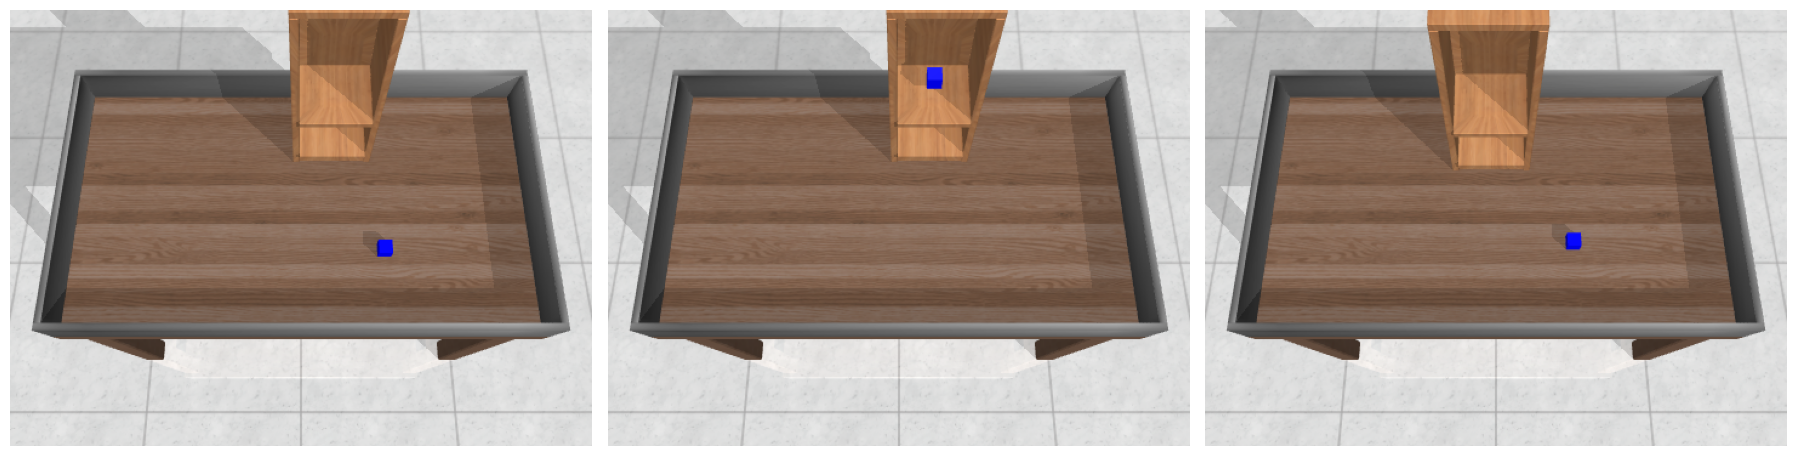

In [329]:
# generate keyframes
# reference keyframes env

# param
env_index = 45
img_height, img_width = 360, 480

# generate env and renderer
env, expert_policy, renderer = env_utils.generate_env_and_renderer(env_index, height=img_height, width=img_width, camera_name="keyframes")
T_world2pixel = cu.get_camera_transform_matrix(env, "keyframes", img_height, img_width)
T_pixel2world = np.linalg.inv(T_world2pixel)


# generate keyframes
keyframe_data = keyframe_utils.generate_keyframes(env, renderer)

img_ref_0 = keyframe_data["img"][0]
img_ref_1 = keyframe_data["img"][1]
depth_ref_0 = keyframe_data["depth"][0]
depth_ref_1 = keyframe_data["depth"][1]

# generate keyframe of current env
img_cur, depth_cur = keyframe_utils.generate_cur_keyframe(env, renderer)

viz2d.plot_images([img_ref_0, img_ref_1, img_cur])

img1 = img_ref_0
img2 = img_ref_1
depth1 = depth_ref_0
depth2 = depth_ref_1

In [265]:
def sample_points(img, depth, T_pixel2world, n_samples=60):
    wpos_kpts, pixel_coords_xy = depth_utils.pixel_coords_to_world_coords_simple(
        T_pixel2world=T_pixel2world, real_depth=depth, return_pixel_coords_xy=True
    )
    mask_table = match_utils.create_feature_table_mask(wpos_kpts)
    
    # do not sample points on edges
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,10,10)
    kernel = np.ones((2,2),np.uint8)
    dilation = cv2.dilate(edges, kernel, iterations = 1)
    # erosion = cv2.erode(dilation, kernel, iterations = 3)
    mask_edges = np.array(dilation) > 0
    mask_edges = mask_edges.reshape(-1)

    mask = mask_table * ~mask_edges
    mask = mask.astype(bool)

    mask = cv2.erode((mask.reshape(img.shape[:2]) * 255).astype(np.uint8), kernel, iterations = 1)
    mask = mask.reshape(-1) > 0
    
    kpts = pixel_coords_xy.copy()
    kpts = kpts[mask]  # (n, 2)

    kpts = kpts[np.random.choice(len(kpts), n_samples, replace=False)]
    return kpts, dilation, mask


def sample_points_superglue(model_fts_extract, img, depth, T_pixel2world, n_samples=60):
    fts = slam_utils.compute_features(model_fts_extract, img)
    fts = torch_utils.to_numpy(fts)
    kpts = fts["keypoints"]
    wpos_kpts, pixel_coords_xy, pixel_coords_xy_adjusted = depth_utils.pixel_coords_to_world_coords(
        T_pixel2world=T_pixel2world, real_depth=depth, pixel_coords_xy=kpts, return_adjusted_pixel_coords_xy=True
    )
    mask_table = match_utils.create_feature_table_mask(wpos_kpts)
    kpts = pixel_coords_xy_adjusted[mask_table]  # (n, 2)
    return kpts[np.random.choice(len(kpts), min(n_samples, len(kpts)), replace=False)]

In [280]:
model_fts_extract = slam_utils.get_super_glue_extractor(device=DEVICE)

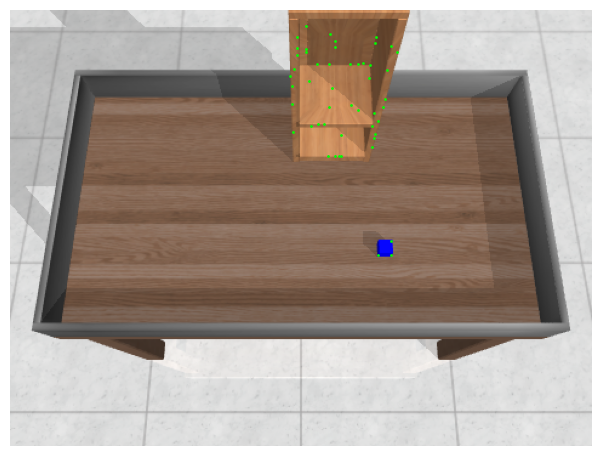

In [337]:
# kpts, dilation, mask = sample_points(img_ref_0, depth_ref_0, T_pixel2world, n_samples=20)
kpts = sample_points_superglue(model_fts_extract, img_ref_0, depth_ref_0, T_pixel2world, n_samples=50)
viz2d.plot_images([img_ref_0])
viz2d.plot_keypoints([kpts])

In [282]:
importlib.reload(iter_fts_match)

<module 'keyframes.notebooks.iterative_feature_matching.iter_fts_match' from '/home/bigboy/Krispin/projects/Metaworld/keyframes/notebooks/iterative_feature_matching/iter_fts_match.py'>

Extracting CLIP features:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessing images...
transferring to device torch.Size([2, 3, 336, 448]) cuda:0
embedding...


Extracting CLIP features: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


iter 0


Extracting CLIP features:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessing images...
transferring to device torch.Size([7, 3, 336, 336]) cuda:0
embedding...


Extracting CLIP features: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


iter 1


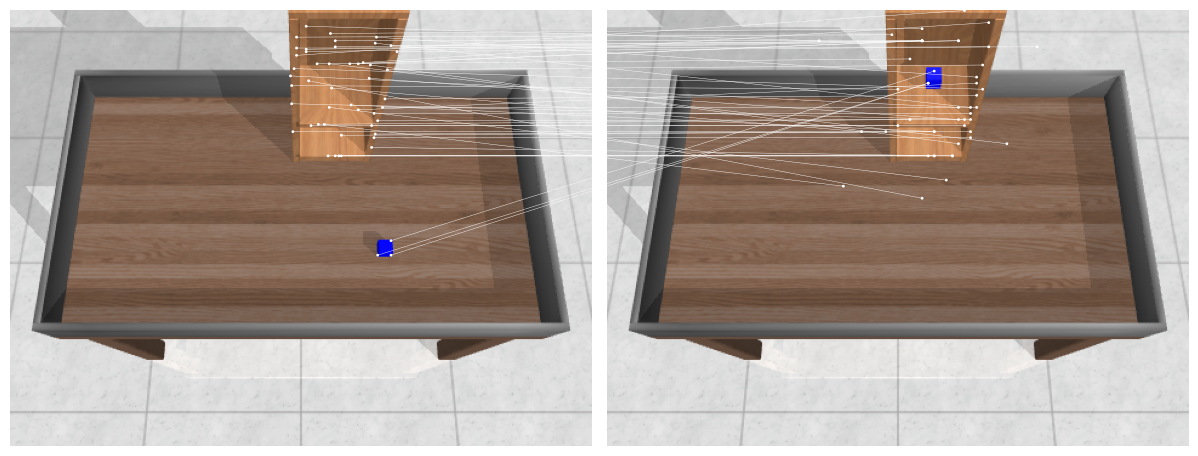

In [338]:
target_xy, all_attns, all_img_crops, all_query_img_crop_ids, all_target_img_crop_ids = iter_fts_match.iterative_feature_matching_fast(
    preprocess=preprocess_image,
    vit_encoder=vit_encoder,
    input_resolution=input_resolution,
    patch_size=patch_size,
    img1=img1,
    img2=img2,
    queries_xy=kpts,
    crop_half_sizes=[60],
    blur_sizes=[3, 0],
    batch_size=8,
    device="cuda:0",
    log=True,
)
viz2d.plot_images([img1, img2])
viz2d.plot_matches(kpts, target_xy, color="white", lw=0.3, ps=1, a=1)

In [208]:
target_xy1 = target_xy.copy()

In [213]:
importlib.reload(iter_fts_match)

<module 'keyframes.notebooks.iterative_feature_matching.iter_fts_match' from '/home/bigboy/Krispin/projects/Metaworld/keyframes/notebooks/iterative_feature_matching/iter_fts_match.py'>

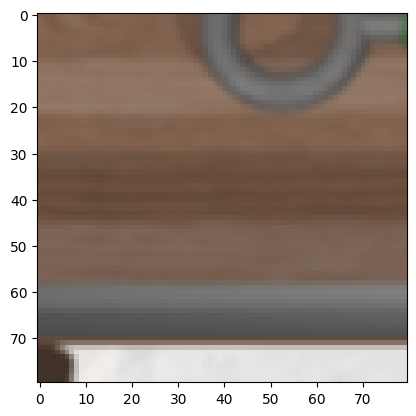

In [231]:
plt.imshow(all_img_crops[1][0][0])

In [258]:
fig = px.imshow(all_attns[0][5])
fig.show()

In [256]:
df = {
    "x": kpts[:, 0],
    "y": -kpts[:, 1],
    "id": np.arange(kpts.shape[0]),
}
px.scatter(df, x="x", y="y", hover_data=["id"])

In [257]:
df = {
    "x": target_xy[:, 0],
    "y": -target_xy[:, 1],
    "id": np.arange(kpts.shape[0]),
}
px.scatter(df, x="x", y="y", hover_data=["id"])

In [214]:
target_xy = np.zeros_like(kpts)
for i in tqdm(range(kpts.shape[0])):
    query_xy_ = kpts[i,:]
    target_xy[i,:], attns, cur_img1_crops, cur_img2_crops = iter_fts_match.iterative_feature_matching(
        preprocess=preprocess_image,
        vit_encoder=vit_encoder,
        input_resolution=input_resolution,
        patch_size=patch_size,
        img1=img1,
        img2=img2,
        query_xy=query_xy_,
        crop_half_sizes=[40, 30, 15, 15],
        blur_sizes=[0, 0, 0, 0],
        batch_size=8,
        device="cuda:0",
        log=False,
    )

100%|██████████| 20/20 [02:16<00:00,  6.81s/it]


In [ ]:
all_attns

In [191]:
all_img_crops[0][1]

[array([[[222, 222, 222],
         [222, 222, 222],
         [222, 223, 222],
         ...,
         [219, 219, 219],
         [219, 219, 219],
         [222, 222, 221]],
 
        [[221, 222, 221],
         [222, 222, 222],
         [222, 223, 223],
         ...,
         [222, 222, 221],
         [221, 221, 220],
         [221, 221, 220]],
 
        [[220, 220, 220],
         [222, 222, 222],
         [222, 223, 223],
         ...,
         [223, 223, 222],
         [222, 222, 222],
         [221, 221, 221]],
 
        ...,
 
        [[223, 223, 223],
         [224, 224, 224],
         [223, 224, 224],
         ...,
         [224, 225, 224],
         [225, 225, 225],
         [225, 226, 225]],
 
        [[223, 224, 223],
         [223, 224, 223],
         [223, 223, 223],
         ...,
         [224, 225, 224],
         [225, 225, 225],
         [224, 224, 224]],
 
        [[223, 224, 224],
         [222, 223, 223],
         [223, 224, 224],
         ...,
         [222, 222, 222],
  

In [187]:
len(all_img_crops[0][0][0])

360

In [183]:
plt.imshow(all_img_crops[0][17][1])

IndexError: tuple index out of range

In [194]:
fig = px.imshow(all_attns[1][17])
fig.show()

In [5]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

In [8]:
model_ckpts_dir = "/home/bigboy/Krispin/model_ckpts"
fts_match_ckpt_path = f"{model_ckpts_dir}/lightglue_epoch=34-step=3885.ckpt"
seg_any_ckpt_path = f"{model_ckpts_dir}/sam_vit_h_4b8939.pth"
mcc_ckpt_path = f"{model_ckpts_dir}/co3dv2_all_categories.pth"

In [9]:
img_res = (360, 480)
sam = sam_model_registry["vit_h"](checkpoint=seg_any_ckpt_path)
mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
masks = mask_generator.generate(img_ref_0)

In [22]:
masks_filtered = []
for mask in masks:
    if mask["area"] > 4 and mask["area"] < 1000:
        masks_filtered.append(mask)

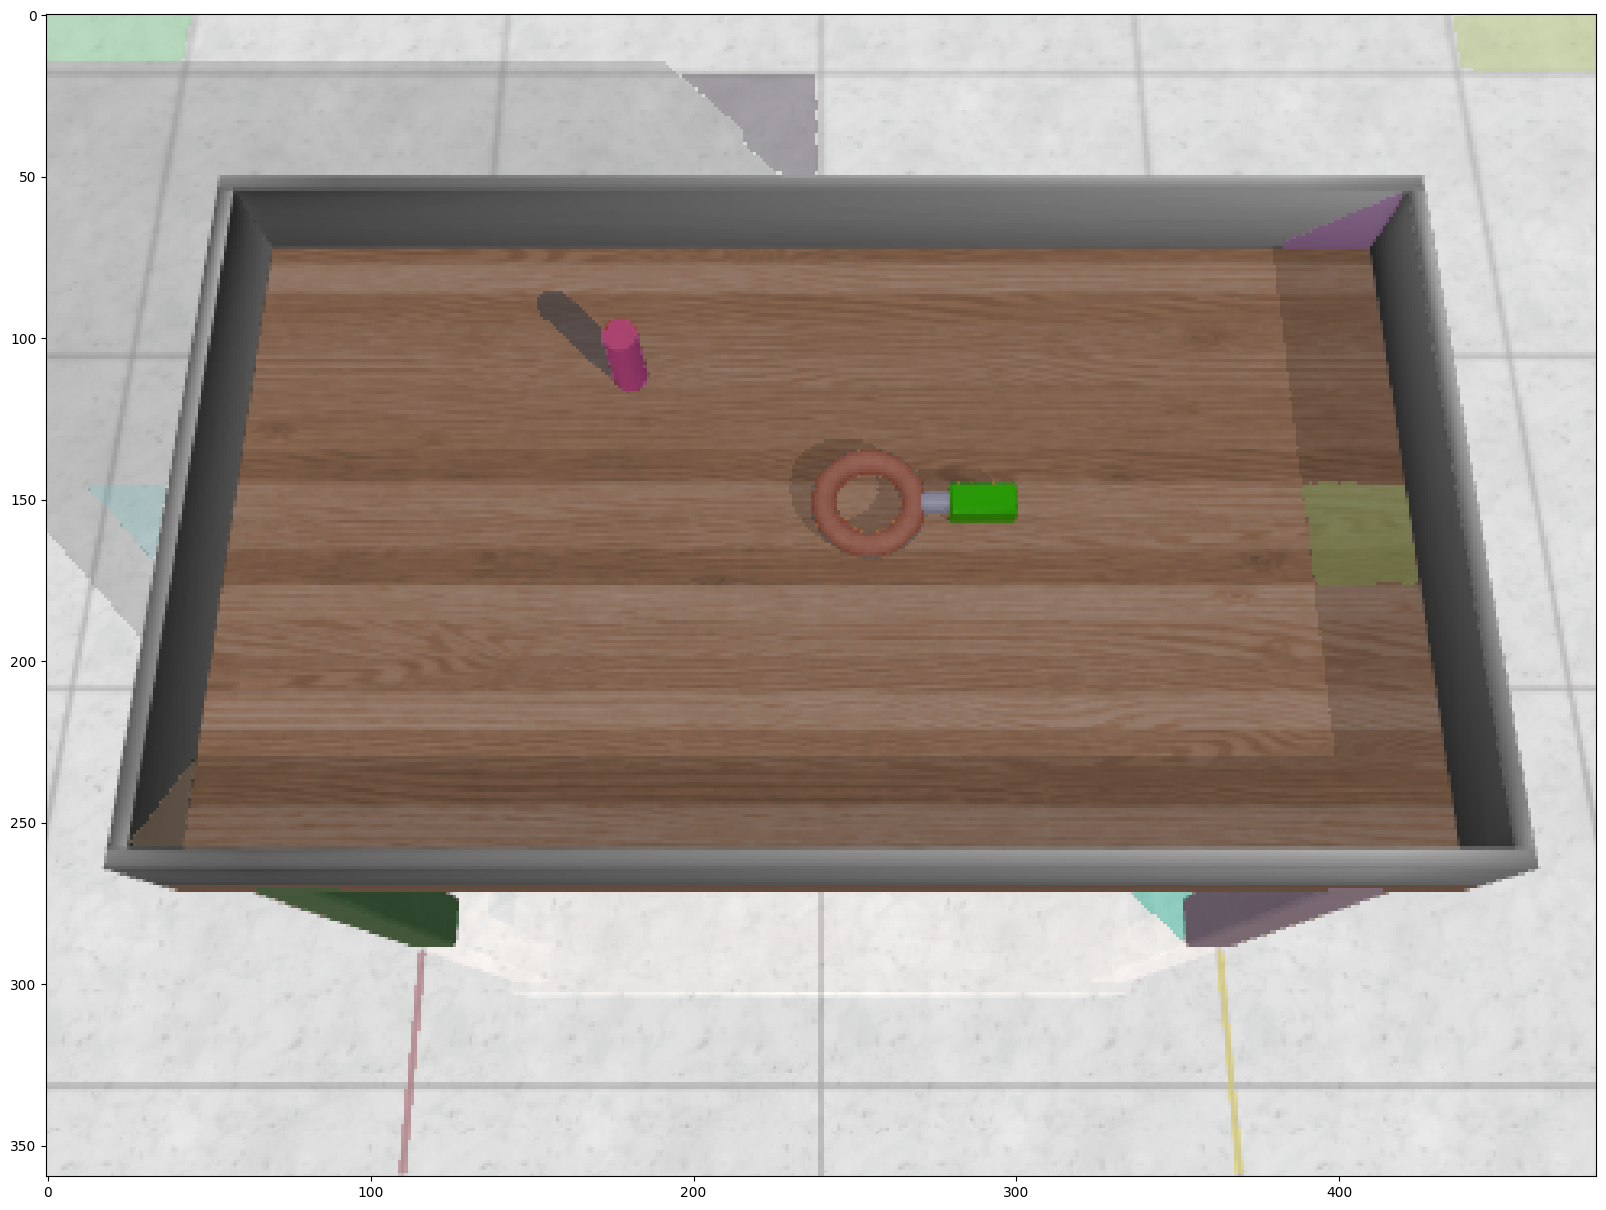

In [25]:
plt.figure(figsize=(20,20))
plt.imshow(img_ref_0)
seg_any.show_anns(masks_filtered)
# plt.axis('off')
plt.show() 


In [16]:
importlib.reload(seg_any)

<module 'keyframes.seg_any' from '/home/bigboy/Krispin/projects/Metaworld/keyframes/seg_any.py'>